In [1]:
import tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
import json
import os
os.chdir('../')
import pickle
import numpy as np
import string, os
from gensim.models import KeyedVectors
import gensim.downloader as api
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional, BatchNormalization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.utils as ku
from sklearn.model_selection import train_test_split
import random
import sys
from datetime import date
from collections import Counter
import matplotlib.pyplot as plt
from src.features.build import Lyrics
from src.features.transform_data import Transform
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

unable to import 'smart_open.gcs', disabling that module


In [2]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']


Shuffling and writing examples to /home/joels/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteQST7T5/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /home/joels/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteQST7T5/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /home/joels/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteQST7T5/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /home/joels/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [3]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [5]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


In [6]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [7]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [8]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(lang1.numpy()) + [tokenizer_pt.vocab_size+1]
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(lang2.numpy()) + [tokenizer_en.vocab_size+1]
    return lang1, lang2

In [9]:
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])

    return result_pt, result_en

In [10]:
MAX_LENGTH = 40

In [11]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)


In [12]:
train_preprocessed = (
    train_examples
    .map(tf_encode) 
    .filter(filter_max_length)
    # cache the dataset to memory to get a speedup while reading from it.
    .cache()
    .shuffle(BUFFER_SIZE))

val_preprocessed = (
    val_examples
    .map(tf_encode)
    .filter(filter_max_length))        

In [17]:
train_dataset = (train_preprocessed
                 .padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))
                 .prefetch(tf.data.experimental.AUTOTUNE))


val_dataset = (val_preprocessed
               .padded_batch(BATCH_SIZE,  padded_shapes=([None], [None])))


In [18]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

In [19]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [30]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

array([[ 0],
       [ 2],
       [ 4],
       [ 6],
       [ 8],
       [10],
       [12],
       [14],
       [16],
       [18],
       [20],
       [22],
       [24],
       [26],
       [28],
       [30],
       [32],
       [34],
       [36],
       [38],
       [40],
       [42],
       [44],
       [46],
       [48]])

(1, 50, 512)


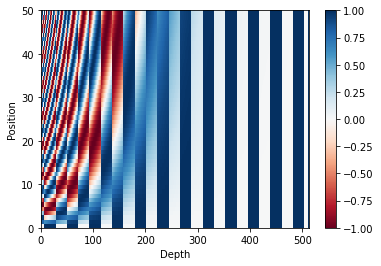

In [21]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()


In [22]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)


In [23]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [44]:
# The look-ahead mask is used to mask the future tokens in a sequence. 
# In other words, the mask indicates which entries should not be used.

#This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, 
#only the first, second and the third word will be used and so on.

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask # (seq_len, seq_len)
x = tf.random.uniform((0,3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [32]:
def scaled_dot_product_attention(q, k, v, mask):
    """
        Calculate the attention weights.
        q, k, v must have matching leading dimensions.
        k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
        The mask has different shapes depending on its type(padding or look ahead)
          but it must be broadcastable for addition.

      Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

      Returns:
        output, attention_weights


    """
    matmul_qk = tf.matmul(q, k, transpose_b=True) #(..., seq_len, seq_len_k)
    

Help on function matrix_band_part in module tensorflow.python.ops.gen_array_ops:

matrix_band_part(input, num_lower, num_upper, name=None)
    Copy a tensor setting everything outside a central band in each innermost matrix
    
    to zero.
    
    The `band` part is computed as follows:
    Assume `input` has `k` dimensions `[I, J, K, ..., M, N]`, then the output is a
    tensor with the same shape where
    
    `band[i, j, k, ..., m, n] = in_band(m, n) * input[i, j, k, ..., m, n]`.
    
    The indicator function
    
    `in_band(m, n) = (num_lower < 0 || (m-n) <= num_lower)) &&
                     (num_upper < 0 || (n-m) <= num_upper)`.
    
    For example:
    
    ```
    # if 'input' is [[ 0,  1,  2, 3]
                     [-1,  0,  1, 2]
                     [-2, -1,  0, 1]
                     [-3, -2, -1, 0]],
    
    tf.matrix_band_part(input, 1, -1) ==> [[ 0,  1,  2, 3]
                                           [-1,  0,  1, 2]
                                       